In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
def ignore_warn(*args, **kwargs):
    pass

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

In [2]:
#Load the Dataset
df = pd.read_csv("games.csv")
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [3]:
df.dtypes

id                 object
rated                bool
created_at        float64
last_move_at      float64
turns               int64
victory_status     object
winner             object
increment_code     object
white_id           object
white_rating        int64
black_id           object
black_rating        int64
moves              object
opening_eco        object
opening_name       object
opening_ply         int64
dtype: object

In [4]:
#Change the column names to clearer terms
df.columns = ['game_id', 'rated_game?', 'start_time', 'end_time', 'num_of_moves',
             'win_type', 'winner', 'increment_code', 'white_id', 'white_rating',
             'black_id', 'black_rating', 'list_of_moves', 'opening_eco', 'opening_name',
             'num_opening_moves']
#Split the increment code into two columns
df[['time', 'added_time']] = df.increment_code.str.split("+",expand=True)

In [5]:
#Change values of the categorical variables
df['rated_game?'][df['rated_game?'] == True] = '1'
df['rated_game?'][df['rated_game?'] == False] = '0'

df['winner'][df['winner'] == 'white'] = '1'
df['winner'][df['winner'] == 'black'] = '0'

df['win_type'][df['win_type'] == 'draw'] = '0'
df['win_type'][df['win_type'] == 'outoftime'] = '0'
df['win_type'][df['win_type'] == 'resign'] = '1'
df['win_type'][df['win_type'] == 'mate'] = '3'

df.head()

,game_id,rated_game?,start_time,end_time,num_of_moves,win_type,winner,increment_code,white_id,white_rating,black_id,black_rating,list_of_moves,opening_eco,opening_name,num_opening_moves,time,added_time
0,TZJHLljE,0,1.504210e+12,1.504210e+12,13,0,1,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,15,2
1,l1NXvwaE,1,1.504130e+12,1.504130e+12,16,1,0,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,5,10
2,mIICvQHh,1,1.504130e+12,1.504130e+12,61,3,1,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,5,10
3,kWKvrqYL,1,1.504110e+12,1.504110e+12,61,3,1,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,20,0
4,9tXo1AUZ,1,1.504030e+12,1.504030e+12,95,3,1,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,30,3


In [6]:
df.dtypes

game_id               object
rated_game?           object
start_time           float64
end_time             float64
num_of_moves           int64
win_type              object
winner                object
increment_code        object
white_id              object
white_rating           int64
black_id              object
black_rating           int64
list_of_moves         object
opening_eco           object
opening_name          object
num_opening_moves      int64
time                  object
added_time            object
dtype: object

In [7]:
#Correct the type of data
df['game_id'] = df['game_id'].astype('category')
df['game_id'] = df['game_id'].cat.codes
df['game_id'] = df['game_id'].astype('object')

df['black_id'] = df['black_id'].astype('category')
df['black_id'] = df['black_id'].cat.codes
df['black_id'] = df['black_id'].astype('object')

df['white_id'] = df['white_id'].astype('category')
df['white_id'] = df['white_id'].cat.codes
df['white_id'] = df['white_id'].astype('object')

df['time'] = df['time'].astype('int')

df.dtypes

game_id               object
rated_game?           object
start_time           float64
end_time             float64
num_of_moves           int64
win_type              object
winner                object
increment_code        object
white_id              object
white_rating           int64
black_id              object
black_rating           int64
list_of_moves         object
opening_eco           object
opening_name          object
num_opening_moves      int64
time                   int32
added_time            object
dtype: object

In [8]:
#drop the start and end time variables as the given data is not formatted correctly
#df = df.drop(['start_time','end_time', 'list_of_moves', 'opening_name', 'white_id', 'black_id'], axis = 1)

df.head()

,game_id,rated_game?,start_time,end_time,num_of_moves,win_type,winner,increment_code,white_id,white_rating,black_id,black_rating,list_of_moves,opening_eco,opening_name,num_opening_moves,time,added_time
0,9068,0,1.504210e+12,1.504210e+12,13,0,1,15+2,1287,1500,11,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,15,2
1,14512,1,1.504130e+12,1.504130e+12,16,1,0,5+10,16,1322,7748,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,5,10
2,14904,1,1.504130e+12,1.504130e+12,61,3,1,5+10,3823,1496,11,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,5,10
3,14350,1,1.504110e+12,1.504110e+12,61,3,1,20+0,2017,1439,134,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,20,0
4,3091,1,1.504030e+12,1.504030e+12,95,3,1,30+3,6056,1523,134,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,30,3


In [9]:
#Create dummy variables
df = pd.get_dummies(df, drop_first=True)
df.head()

,start_time,end_time,num_of_moves,white_rating,black_rating,num_opening_moves,time,game_id_1,game_id_2,game_id_3,...,added_time_4,added_time_40,added_time_45,added_time_5,added_time_6,added_time_60,added_time_7,added_time_8,added_time_9,added_time_90
0,1.504210e+12,1.504210e+12,13,1500,1191,5,15,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.504130e+12,1.504130e+12,16,1322,1261,4,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.504130e+12,1.504130e+12,61,1496,1500,3,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.504110e+12,1.504110e+12,61,1439,1454,3,20,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.504030e+12,1.504030e+12,95,1523,1469,5,30,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('winner_1', 1), df['winner_1'], test_size = .2, random_state=10) #split the data

In [11]:
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

In [12]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [13]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

In [14]:
confusion_matrix = confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[1541,  461],
       [1170,  840]], dtype=int64)

In [15]:
sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.5684249354481741
Specificity :  0.6456571867794004


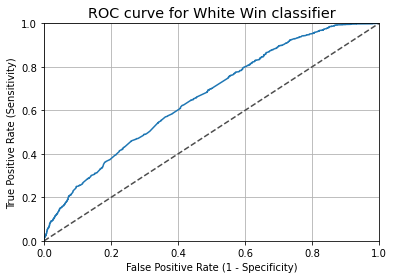

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for White Win classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [17]:
auc(fpr, tpr)

0.6601807396583516

In [18]:
#perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
#eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [19]:
#explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(X_test)

#shap.summary_plot(shap_values[1], X_test, plot_type="bar")

In [20]:
#shap.summary_plot(shap_values[1], X_test)